# Tohoku tsunami inversion
## 8. Inversion using discrete adjoint in P1 basis

Instead of using radial basis functions, we could just use the $\mathbb P1$ basis native to the mesh.
We restrict the region where the source can be non-zero to a $[280\;\mathrm{km}\times560\;\mathrm{km}]$ rectangle.

In [1]:
%matplotlib inline

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.swe.tsunami.conversion import from_latlon
from adapt_utils.misc import box, ellipse #, bump

Misc plotting routines

In [5]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [6]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [7]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

In [10]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
op.gauges.pop('21418')  # This pressure gauge isn't within the domain

mesh = op.default_mesh
P1 = FunctionSpace(mesh, "CG", 1)
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
TaylorHood = P2_vec*P1

boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

### Forward model

As before, consider the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Define fields for forward model, e.g. bathymetry from GEBCO.

In [11]:
b = Function(P1, name="Bathymetry").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))
# plot_fields(eta_init, b, f);

In [12]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()
eta.dat.name = "Final surface"

bc = DirichletBC(TaylorHood.sub(1), 0, 100)

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bc)
solver = LinearVariationalSolver(problem, solver_parameters=params)

We use the initial free surface computed using inversion in __[Saito et al. 2011]__ as an initial guess.

Note that if we were to invert w.r.t. the full initial condition then we would very likely get non-zero initial velocity.
As such, we filter the initial condition using a kernel function which zeroes out the velocity.

In addition, we assume that the initial free surface is only non-zero in a rectangular region aligned with the fault centred at the earthquake epicentre, of widths 280km and 140km parallel and perpendicular to the fault, resp.
This is accounted for in the free surface component of the kernel function.

In [13]:
initial_surface = Function(P1, name="Initial surface")  # This is the field we will be optimising
initial_surface.interpolate(op.set_initial_surface(P1));

In [14]:
xy = tuple(from_latlon(38.0, 143.2, force_zone_number=54))
radii = (140e+03, 280e+03)
angle = pi/10
loc = [xy + radii, ]

kernel = Function(TaylorHood)
kernel_u, kernel_eta = kernel.split()
kernel_eta.interpolate(box(loc, mesh, rotation=angle));

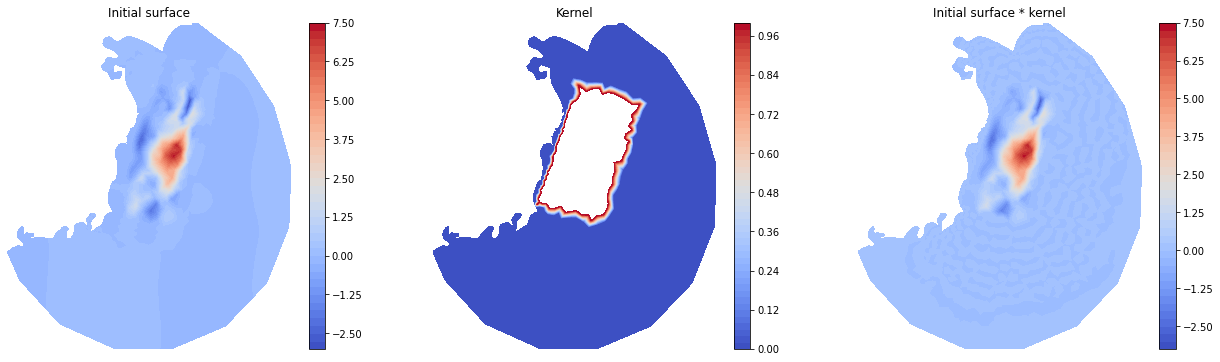

In [15]:
q_.project(kernel*initial_surface)
u_, eta_ = q_.split()
u_.dat.name = "Initial velocity * kernel"
eta_.dat.name = "Initial surface * kernel"
kernel_eta.dat.name = "Kernel"
axes = plot_fields(initial_surface, kernel_eta, eta_, height=6);

In [17]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    x, y = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([(x, y, radius), ], mesh), P0)

In [18]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
                
    interp = scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')
    init = interp(0.0)
    
    def shifted(tau):
        return interp(tau) - init
    
    return shifted

In [24]:
for gauge in op.gauges:
    op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=60 if gauge[0] == 'P' else 1)

Now run the forward model, time integrating the QoI as time progresses.

In [25]:
t = 0.0
iteration = 0
J = 0
# op.end_time = 3600.0
op.end_time = 1440.0  # TODO: TEMPORARY
t_obs = Constant(op.dt)
eta_obs = Constant(0.0)
weight = Constant(1.0)
while t < op.end_time:
    solver.solve()
    
    # Time integrate QoI
    weight.assign(0.5 if np.allclose(t, 0.0) else 1.0)
    u, eta = q.split()
    for gauge in op.gauges:

        # Interpolate observations
        obs = float(op.gauges[gauge]['interpolator'](t))
        eta_obs.assign(obs)

        # Continuous form of error
        diff = 0.5*op.gauges[gauge]['indicator']*(eta - eta_obs)**2
        J += assemble(weight*dtc*diff*dx)
        
    q_.assign(q)
    t += op.dt
    iteration += 1
assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
print("Quantity of interest = {:.4e}".format(J))

Quantity of interest = 9.5016e+12


Compare initial and final solution

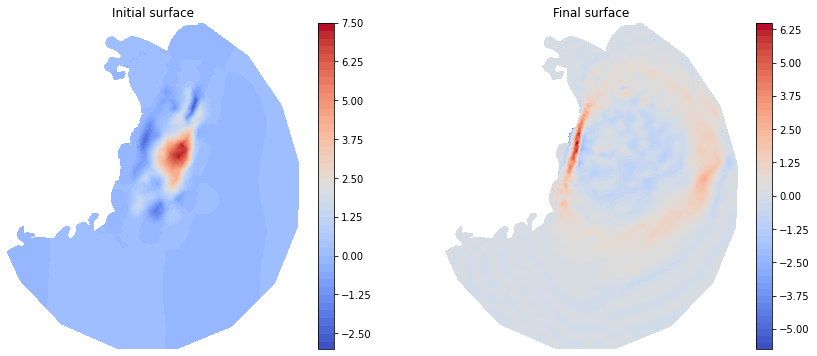

In [27]:
initial_surface.dat.name = 'Initial surface'
plot_fields(initial_surface, eta, height=6);

## Inversion in the P1 basis

In [28]:
opt_kwargs = {
    'maxiter': 5,
    'gtol': 1.0,
}

def derivative_cb_post(j, dj, m):
    print("functional value {:.8e}  norm of gradient {:.8e}".format(j, norm(dj)))

Jhat = ReducedFunctional(J, Control(initial_surface), derivative_cb_post=derivative_cb_post)

In [ ]:
ic_opt = minimize(Jhat, method='BFGS', options=opt_kwargs)

functional value 4.54175884e+11  derivatives 3.82393457e+14  values 7.87737457e+05
functional value 4.23413828e+11  derivatives 3.52686586e+14  values 7.87409153e+05
functional value 3.24112045e+11  derivatives 2.41358724e+14  values 7.87914763e+05
functional value 1.80745790e+11  derivatives 1.04778659e+14  values 8.12053920e+05
functional value 1.46691247e+11  derivatives 9.34704612e+13  values 8.27128734e+05
functional value 1.21553545e+11  derivatives 6.43905137e+13  values 8.55904756e+05
functional value 1.10727268e+11  derivatives 4.82646431e+13  values 8.64098108e+05
functional value 1.03810276e+11  derivatives 3.47684126e+13  values 8.69549045e+05
functional value 9.72851013e+10  derivatives 3.13507311e+13  values 8.83325773e+05
functional value 9.36646663e+10  derivatives 4.96649656e+13  values 9.04820275e+05
functional value 8.99895575e+10  derivatives 2.23215830e+13  values 9.10512519e+05
functional value 8.74865609e+10  derivatives 1.91007690e+13  values 9.18460849e+05
func

In [ ]:
ic_opt.dat.name = "Optimised elevation"

surface_diff = Function(P1, name="Difference in surface")
surface_diff.interpolate(abs(initial_surface - ic_opt))

plot_fields(initial_surface, ic_opt, surface_diff);

Now that we've computed the optimised basis function, run the forward model again to see whether the timeseries match the data better.

# [TODO]